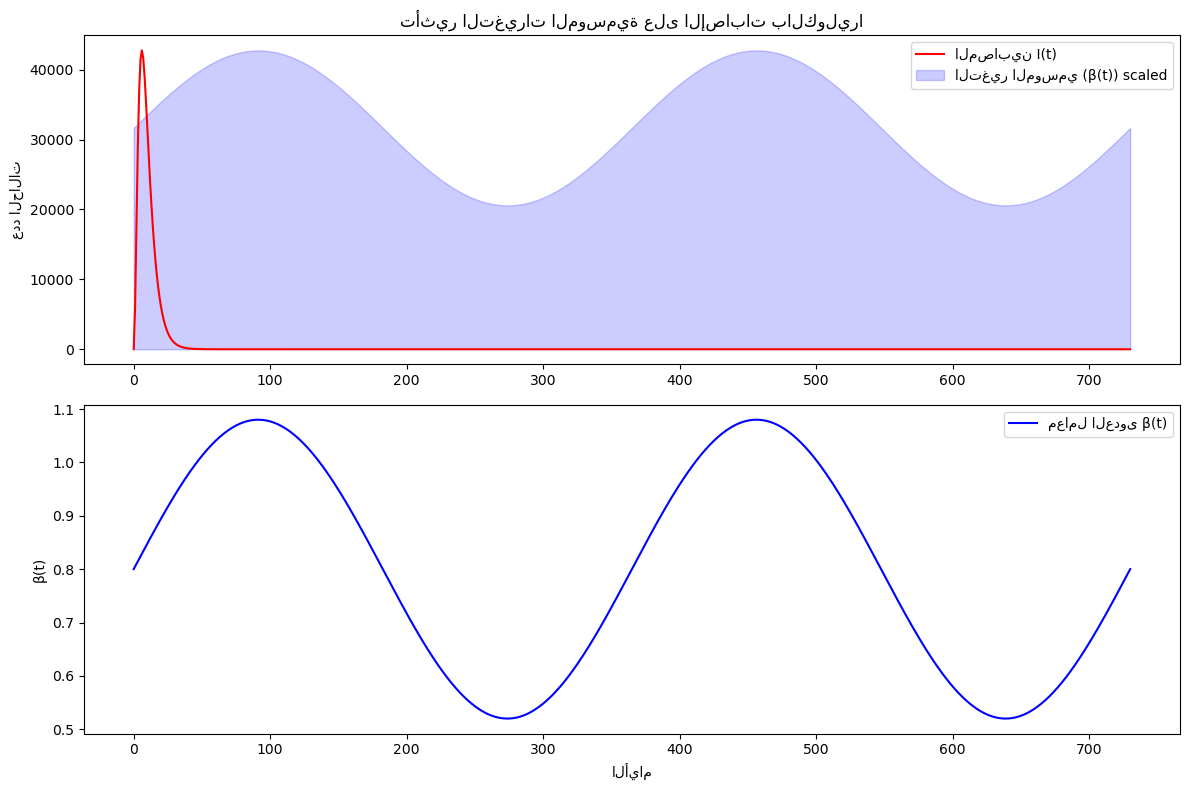

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ---------------------------
# دوال مساعدة
# ---------------------------
def seasonal_beta(t, beta0, amp, period_days=365.0, phase=0.0):
    """معامل العدوى الموسمي"""
    return beta0 * (1.0 + amp * np.sin(2*np.pi*(t/period_days) + phase))

def seirc_model(t, y, N, params):
    """نموذج SEIRC مع خزان ماء وتأثير موسمي"""
    S, E, I, R, C = y
    beta0 = params['beta0']
    amp = params['amp']
    period = params['period_days']
    phi = params['phase']
    sigma = params['sigma']
    gamma = params['gamma']
    muC = params['muC']
    alpha = params['alpha']
    kappa = params['kappa']
    beta_water = params['beta_water']

    beta_t = seasonal_beta(t, beta0, amp, period, phi)
    lambda_inf = (beta_t * I / N) + (beta_water * C / (kappa + C))

    dSdt = - lambda_inf * S
    dEdt =   lambda_inf * S - sigma * E
    dIdt =   sigma * E - gamma * I
    dRdt =   gamma * I
    dCdt =   alpha * I - muC * C

    return [dSdt, dEdt, dIdt, dRdt, dCdt]

# ---------------------------
# إعداد المعاملات
# ---------------------------
N = 100_000
params = {
    'beta0': 0.8,
    'amp': 0.35,
    'period_days': 365.0,
    'phase': 0.0,
    'sigma': 1/3.0,
    'gamma': 1/5.0,
    'alpha': 10.0,
    'muC': 1/30.0,
    'kappa': 1.0,
    'beta_water': 0.5
}

# الحالات الابتدائية
I0, E0, R0, C0 = 10, 5, 0, 0.1
S0 = N - (I0 + E0 + R0)
y0 = [S0, E0, I0, R0, C0]

# زمن المحاكاة
days = 365 * 2
t_eval = np.linspace(0, days, int(days)+1)

# حل النظام
sol = solve_ivp(fun=lambda t,y: seirc_model(t,y,N,params),
                t_span=(t_eval[0], t_eval[-1]),
                y0=y0, t_eval=t_eval,
                rtol=1e-6, atol=1e-8)

S, E, I, R, C = sol.y
t = sol.t
beta_t = seasonal_beta(t, params['beta0'], params['amp'], params['period_days'], params['phase'])

# ---------------------------
# الرسم البياني
# ---------------------------
plt.figure(figsize=(12,8))

# 1) الإصابات مع إظهار التغير الموسمي
plt.subplot(2,1,1)
plt.plot(t, I, label='المصابين I(t)', color='red')
plt.fill_between(t, beta_t*max(I)/max(beta_t), alpha=0.2, color='blue',
                 label='التغير الموسمي (β(t)) scaled')
plt.ylabel('عدد الحالات')
plt.legend()
plt.title('تأثير التغيرات الموسمية على الإصابات بالكوليرا')

# 2) إظهار منحنى β(t) نفسه
plt.subplot(2,1,2)
plt.plot(t, beta_t, label='معامل العدوى β(t)', color='blue')
plt.xlabel('الأيام')
plt.ylabel('β(t)')
plt.legend()

plt.tight_layout()
plt.show()


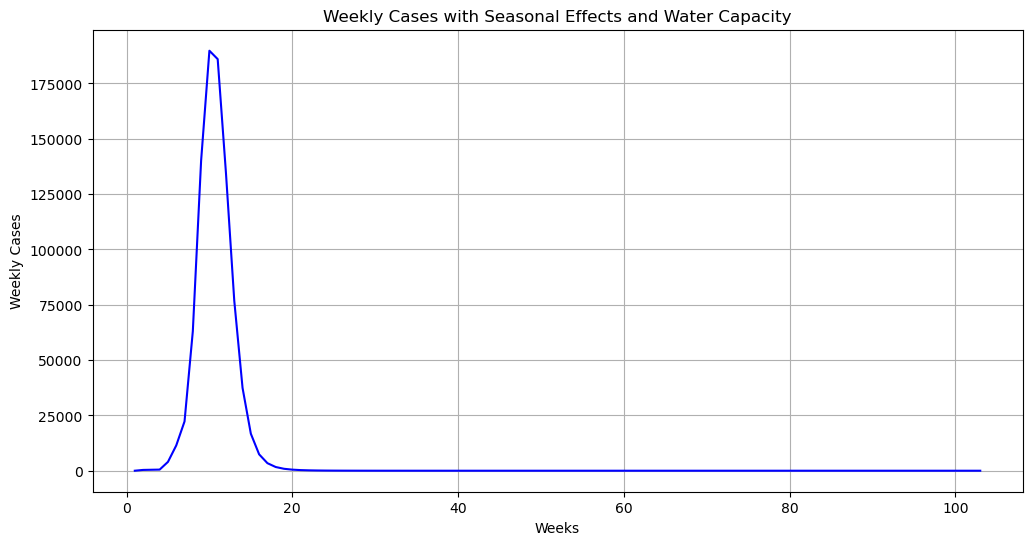

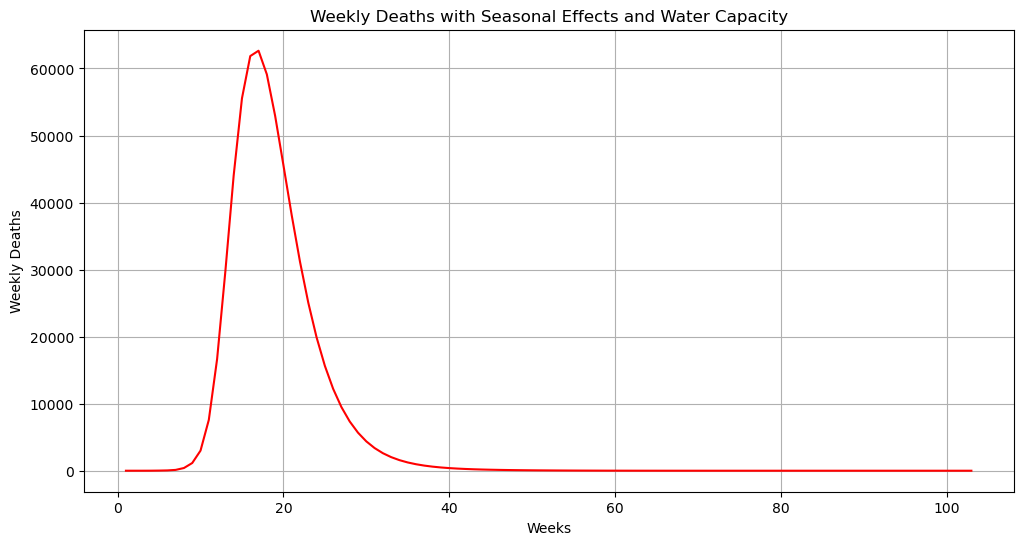

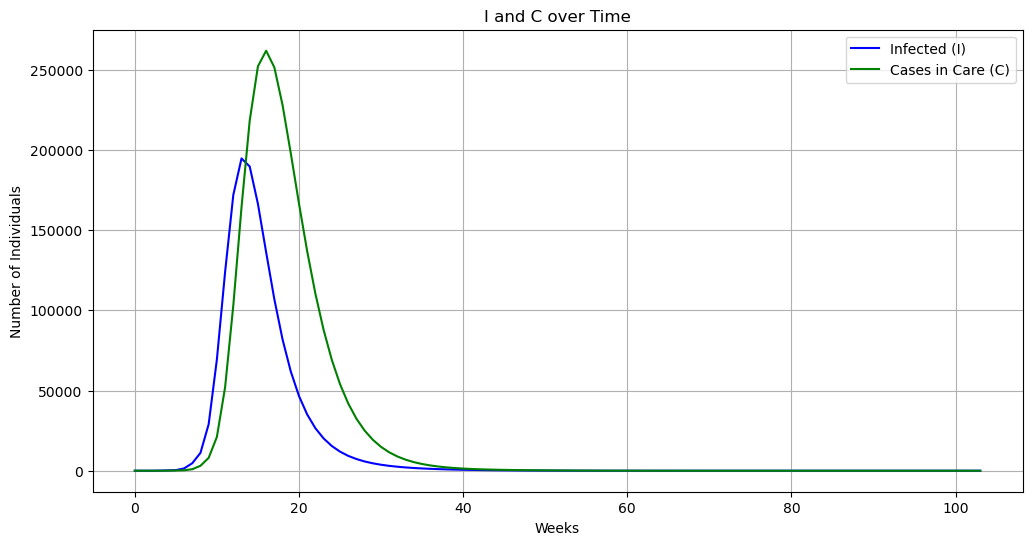

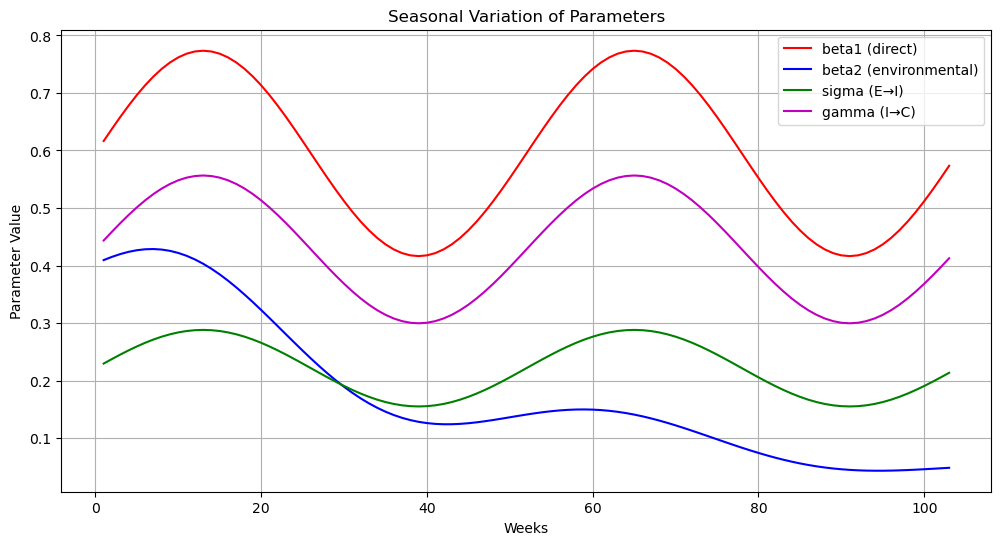

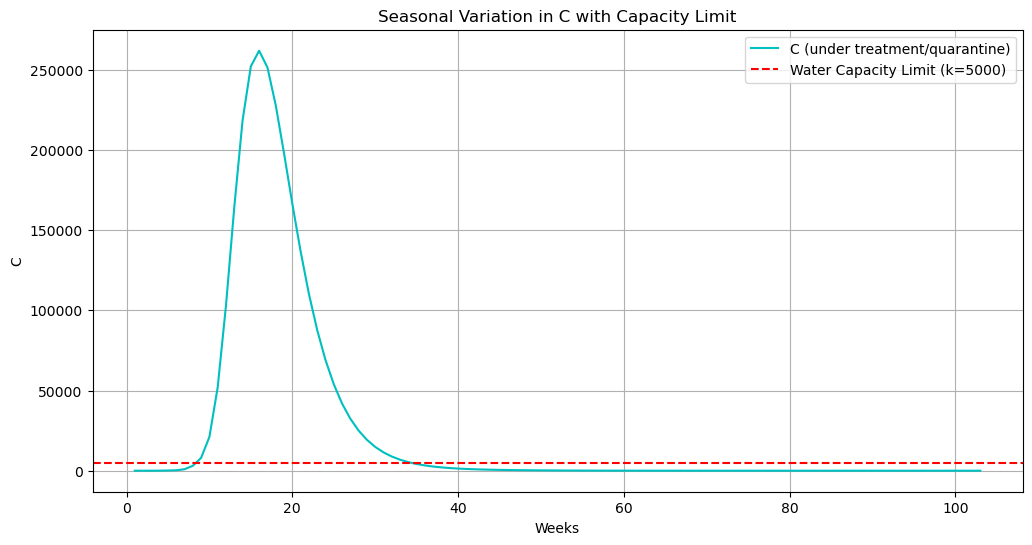

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# دالة المحاكاة SEICR مع تدخلات + موسمية + سعة استيعابية
# ==============================
def simulate_seicr(years, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                   phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                   dry_rate=0.0, k_capacity=5000,
                   season_amp=0.3):
    """
    years: np.array تمثل الأسابيع
    N: عدد السكان الكلي
    معاملات النموذج: beta1, beta2, sigma, gamma, mu, delta, eta
    التدخلات:
      - phi_max: نسبة التنقية
      - theta: نسبة العزل
      - vacc_rate: معدل التطعيم الأسبوعي
      - ve: فعالية التطعيم
      - vacc_delay: تأخير فعالية التطعيم
      - dry_rate: معدل جفاف مصادر المياه (0 = لا جفاف، 0.05 = 5% أسبوعي)
      - k_capacity: السعة الاستيعابية للمياه
      - season_amp: شدة التذبذب الموسمي (0.3 = ±30%)
    """
    # الحالة الابتدائية
    S0 = N - 10
    E0 = 0
    I0 = 10
    C0 = 0
    R0 = 0
    D0 = 0
    Vwaiting = 0

    S, E, I, C, R, D = [S0], [E0], [I0], [C0], [R0], [D0]
    Vwait = [Vwaiting]
    cases, deaths = [], []

    # حفظ المعاملات الموسمية
    beta1_list, beta2_list, sigma_list, gamma_list, C_list = [], [], [], [], []

    for t in range(1, len(years)):
        # تذبذب موسمي بالجيب (سنة = 52 أسبوع)
        season_factor = 1 + season_amp * np.sin(2 * np.pi * t / 52)

        # معاملات موسمية + تدخلات
        beta1_eff = beta1 * (1 - theta) * season_factor
        beta2_eff = beta2 * (1 - phi_max) * (1 - dry_rate) ** t * season_factor
        sigma_eff = sigma * season_factor
        gamma_eff = gamma * (1 + 0.5 * theta) * season_factor
        eta_eff   = eta * (1 + 0.3 * theta)

        # الإصابات الجديدة
        new_exposed = (beta1_eff * S[-1] * I[-1] / N) + (beta2_eff * S[-1] * C[-1] / (k_capacity + C[-1]))
        new_exposed = min(new_exposed, S[-1])

        # التطعيم
        new_vacc = min(vacc_rate * S[-1], S[-1])
        Vwaiting = Vwait[-1] + new_vacc
        if t >= vacc_delay:
            new_protected = ve * Vwait[-vacc_delay]
        else:
            new_protected = 0

        # تحديث المعادلات
        S_next = S[-1] - new_exposed - new_vacc
        E_next = E[-1] + new_exposed - sigma_eff * E[-1]
        I_next = I[-1] + sigma_eff * E[-1] - gamma_eff * I[-1] - mu * I[-1]
        C_next = (C[-1] + gamma_eff * I[-1] - delta * C[-1] - eta_eff * C[-1]) * (1 - dry_rate)
        R_next = R[-1] + delta * C[-1] + new_protected
        D_next = D[-1] + mu * I[-1] + eta_eff * C[-1]

        # قيود
        S_next, E_next = max(S_next, 0), max(E_next, 0)
        I_next, C_next = max(I_next, 0), max(C_next, 0)
        R_next, D_next = max(R_next, 0), max(D_next, 0)

        # حفظ
        S.append(S_next)
        E.append(E_next)
        I.append(I_next)
        C.append(C_next)
        R.append(R_next)
        D.append(D_next)
        Vwait.append(Vwaiting)

        cases.append(new_exposed)
        deaths.append(D_next - D[-2])

        # حفظ المعاملات
        beta1_list.append(beta1_eff)
        beta2_list.append(beta2_eff)
        sigma_list.append(sigma_eff)
        gamma_list.append(gamma_eff)
        C_list.append(C_next)

    return (np.array(cases), np.array(deaths), np.array(I), np.array(R), np.array(C),
            np.array(beta1_list), np.array(beta2_list), np.array(sigma_list), np.array(gamma_list), np.array(C_list))

# ==============================
# مثال تشغيل
# ==============================
years = np.arange(0, 104)  # سنتين
params = (0.743622, 0.576105, 0.221655, 0.389172, 0.043503, 0.085383, 0.204294)

results = simulate_seicr(years, 1_000_000, *params, phi_max=0.3, theta=0.2, vacc_rate=0.01,
                         dry_rate=0.02, k_capacity=5000, season_amp=0.3)

cases, deaths, I, R, C, beta1_eff, beta2_eff, sigma_eff, gamma_eff, C_list = results

# ==============================
# الرسوم البيانية
# ==============================

# الإصابات الأسبوعية
plt.figure(figsize=(12,6))
plt.plot(years[1:], cases, "-b")
plt.xlabel("Weeks")
plt.ylabel("Weekly Cases")
plt.title("Weekly Cases with Seasonal Effects and Water Capacity")
plt.grid(True)
plt.show()

# الوفيات الأسبوعية
plt.figure(figsize=(12,6))
plt.plot(years[1:], deaths, "-r")
plt.xlabel("Weeks")
plt.ylabel("Weekly Deaths")
plt.title("Weekly Deaths with Seasonal Effects and Water Capacity")
plt.grid(True)
plt.show()

# الحالات النشطة I و C
plt.figure(figsize=(12,6))
plt.plot(years, I, "-b", label="Infected (I)")
plt.plot(years, C, "-g", label="Cases in Care (C)")
plt.xlabel("Weeks")
plt.ylabel("Number of Individuals")
plt.title("I and C over Time")
plt.legend()
plt.grid(True)
plt.show()

# القيم الموسمية للمعاملات
plt.figure(figsize=(12,6))
plt.plot(years[1:], beta1_eff, "-r", label="beta1 (direct)")
plt.plot(years[1:], beta2_eff, "-b", label="beta2 (environmental)")
plt.plot(years[1:], sigma_eff, "-g", label="sigma (E→I)")
plt.plot(years[1:], gamma_eff, "-m", label="gamma (I→C)")
plt.xlabel("Weeks")
plt.ylabel("Parameter Value")
plt.title("Seasonal Variation of Parameters")
plt.legend()
plt.grid(True)
plt.show()

# التغيرات الموسمية على C
plt.figure(figsize=(12,6))
plt.plot(years[1:], C_list, "-c", label="C (under treatment/quarantine)")
plt.axhline(5000, color="r", linestyle="--", label="Water Capacity Limit (k=5000)")
plt.xlabel("Weeks")
plt.ylabel("C")
plt.title("Seasonal Variation in C with Capacity Limit")
plt.legend()
plt.grid(True)
plt.show()


Fitting parameters to the first 15 weeks... (this may take some seconds)

Fitted parameters:
beta1 = 0.164945
beta2 = 0.002404
sigma = 0.318891
gamma = 0.050000
mu    = 0.200000
delta = 0.999998
eta   = 0.493445


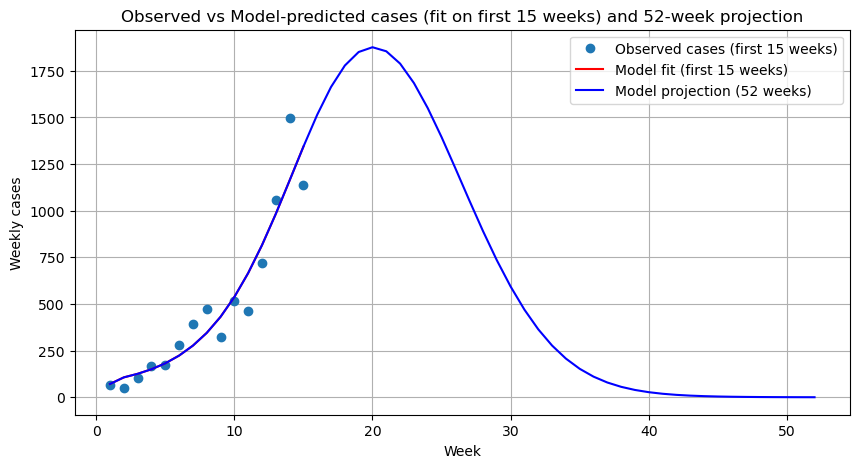

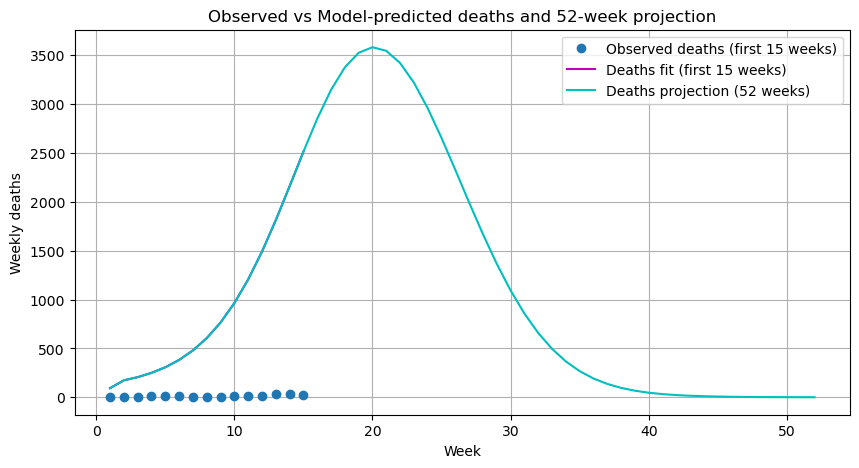

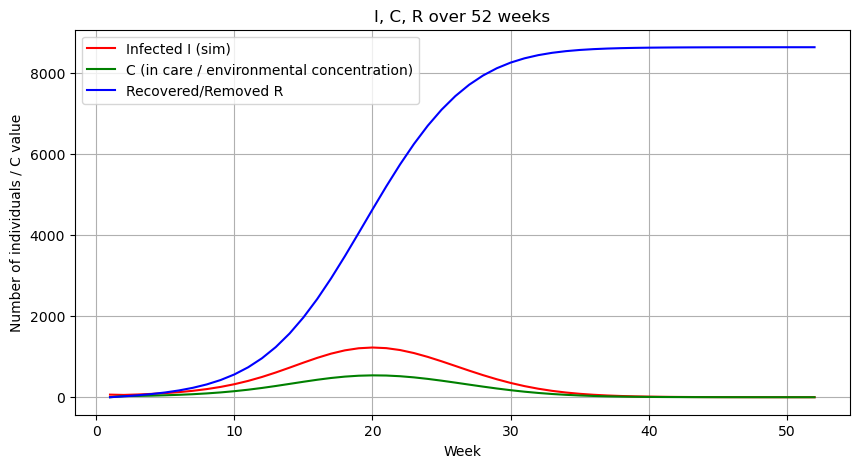

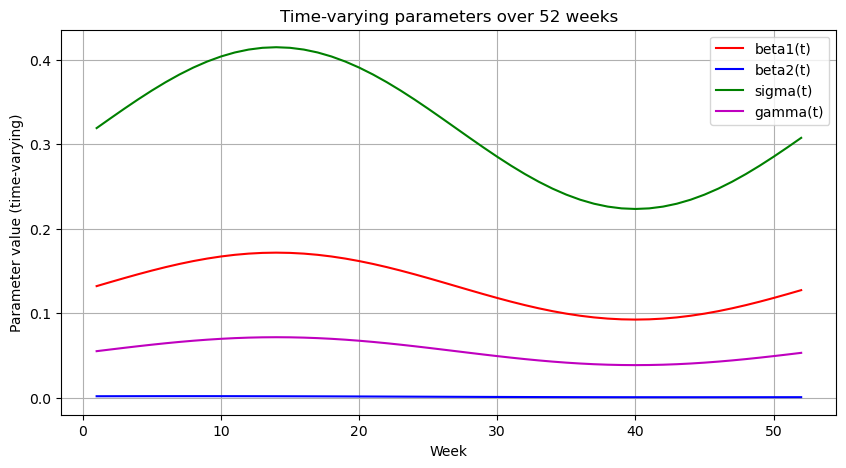

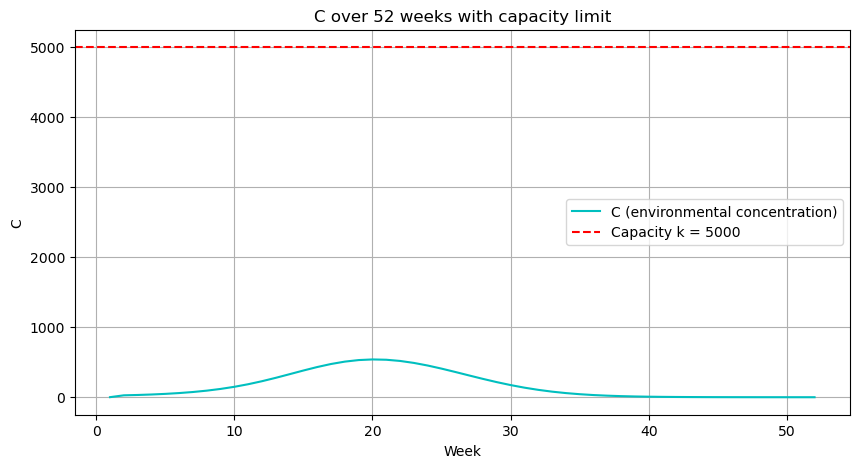

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# ------------------------------
# بيانات المستخدم (أسبوعية: أول 15 أسبوع)
# ------------------------------
weeks_fit = np.arange(1, 16)  # أسابيع بيانات الملاءمة (1..15)
cases_data = np.array([
    64, 52, 101, 168, 175,
    279, 393, 472, 324, 517,
    460, 722, 1059, 1495, 1140
], dtype=float)
deaths_data = np.array([
    4, 2, 7, 14, 11,
    12, 8, 7, 8, 13,
    18, 18, 30, 32, 21
], dtype=float)

# ------------------------------
# محاكاة لمدة سنة (52 أسبوع) بحسب طلبك
# ------------------------------
weeks_sim = np.arange(1, 53)  # 52 أسبوع (سنة واحدة)

# ------------------------------
# ثوابت/خيارات نموذجية
# ------------------------------
N = 1_000_000
k_capacity = 5000          # سعة استيعابية للمصدر/التركيز البيئي كما طلبت
season_amp = 0.30          # شدة التذبذب الموسمي (±30%)
dry_rate_base = 0.02       # معدل جفاف أسبوعي ثابت (يمكن جعله موسمي عن طريق dry_amp)
phi_max_default = 0.0      # تنقية افتراضية
theta_default = 0.0        # عزل افتراضي
vacc_rate_default = 0.0    # تطعيم اسبوعي افتراضي (نسبة من S)
ve_default = 0.8
vacc_delay_default = 2

# ------------------------------
# نموذج SEICR (ODE) مع معاملات زمنية (موسمية/تدخل/جفاف)
# المعادلات تحسب بدلالة الزمن (t بالايام) داخل solve_ivp
# ------------------------------
def seicr_model(t, y, N,
                beta1_base, beta2_base, sigma_base, gamma_base, mu,
                delta, eta,
                phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                dry_rate_base=0.0, season_amp=0.0, k_capacity=5000):
    # t بالايام -> نحسب الأسبوع المقابل (جعل المدد أسبوعي مهم للتذبذب)
    week = t / 7.0
    # عامل موسمي دوري سنوي (52 أسبوع)
    season_factor = 1.0 + season_amp * np.sin(2 * np.pi * week / 52.0)

    # معامل الجفاف يمكن أن يكون متناقص أُسّي عبر الأسابيع: (1-dry)^week
    dry_factor = (1 - dry_rate_base) ** week

    # معاملات زمنية (فعّالة)
    beta1 = beta1_base * (1 - theta) * season_factor
    beta2 = beta2_base * (1 - phi_max) * dry_factor * season_factor
    sigma = sigma_base * season_factor
    gamma = gamma_base * (1 + 0.5 * theta) * season_factor
    eta_eff = eta * (1 + 0.3 * theta)

    S, E, I, R, C = y

    # قوة العدوى
    lam = (beta1 * I / N) + (beta2 * C / (k_capacity + C))

    # معادلات
    dS = -lam * S - vacc_rate * S   # نخصم التطعيم كخروج من S (تبسيط)
    dE = lam * S - sigma * E
    dI = sigma * E - (gamma + mu) * I
    dR = gamma * I + vacc_rate * S * ve  # نعتبر التطعيم يذهب فورا إلى المناعة مع ve (تبسيط)
    dC = eta * I * (1 - C / k_capacity) - delta * C

    return [dS, dE, dI, dR, dC]

# ------------------------------
# دالة للمحاكاة عبر أسابيع محددة
# ترجع: weekly_cases, weekly_deaths, I_vals, R_vals, C_vals و time (أسابيع)
# weekly_cases = تقديري كـ sigma*E (معدل الدخول إلى I) مضروب في 7 (أيام/أسبوع)
# weekly_deaths = (mu*I + eta*C)*7 تقريبي (الوفيات من I وC)
# ------------------------------
def simulate_seicr_ode(weeks_array, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                       phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                       dry_rate_base=0.0, season_amp=0.0, k_capacity=5000,
                       I0=None):
    # تحويل الأسابيع إلى نقاط زمنية بالايام (نبدأ من اليوم 0)
    t_eval_days = ((weeks_array - weeks_array[0]) * 7.0)
    t_span = (t_eval_days[0], t_eval_days[-1])

    # بدايات الحالة
    if I0 is None:
        I0 = max(1.0, cases_data[0])  # استخدام أول قيمة حالات كـ I0 إن وُجدت
    S0 = max(N - I0, 0)
    E0 = I0 * 0.5  # تخمين بداية E (يمكن تعديل)
    R0 = 0.0
    C0 = 1.0
    y0 = [S0, E0, I0, R0, C0]

    sol = solve_ivp(seicr_model, t_span, y0,
                    args=(N, beta1, beta2, sigma, gamma, mu, delta, eta,
                          phi_max, theta, vacc_rate, ve, vacc_delay,
                          dry_rate_base, season_amp, k_capacity),
                    t_eval=t_eval_days, rtol=1e-6, atol=1e-8, method='RK45')

    if not sol.success:
        raise RuntimeError("ODE solver failed")

    S_vals, E_vals, I_vals, R_vals, C_vals = sol.y

    # تحويل المخرجات إلى حالات وأعداد أسبوعية تقريبية
    weekly_cases = np.maximum(sigma * E_vals * 7.0, 0.0)          # من E إلى I خلال الأسبوع
    weekly_deaths = np.maximum((mu * I_vals + eta * C_vals) * 7.0, 0.0)

    # نرجع أيضا مسارات المعاملات المحسوبة عند نقاط الأسابيع لعمل الرسوم
    weeks_points = (t_eval_days / 7.0)  # يبدأ غالبا من 0..n
    season_factor_points = 1.0 + season_amp * np.sin(2 * np.pi * weeks_points / 52.0)
    dry_factor_points = (1 - dry_rate_base) ** weeks_points

    beta1_ts = beta1 * (1 - theta) * season_factor_points
    beta2_ts = beta2 * (1 - phi_max) * dry_factor_points * season_factor_points
    sigma_ts = sigma * season_factor_points
    gamma_ts = gamma * (1 + 0.5 * theta) * season_factor_points

    return (weekly_cases, weekly_deaths, I_vals, R_vals, C_vals, weeks_points,
            beta1_ts, beta2_ts, sigma_ts, gamma_ts)

# ------------------------------
# دالة للملاءمة: تستخدم بيانات الحالات (أسابيع 1..15)
# تُعيد معلمات مُقدَّرة
# ------------------------------
def fit_parameters(weeks_obs, cases_obs, N,
                   p0=None, bounds=None,
                   phi_max=0.0, theta=0.0, vacc_rate=0.0,
                   dry_rate_base=0.0, season_amp=0.0, k_capacity=5000):
    if p0 is None:
        p0 = [0.5, 0.3, 1/5, 0.4, 0.02, 0.08, 0.1]  # β1,β2,σ,γ,μ,δ,η
    if bounds is None:
        lower = [0, 0, 1/12, 0.1, 0.0001, 0.01, 0]
        upper = [3, 3, 1/2, 1.0, 0.2, 1.0, 2.0]
        bounds = (lower, upper)

    def fit_func_short(weeks_input, beta1, beta2, sigma, gamma, mu, delta, eta):
        try:
            weekly_cases, _, _, _, _, _, _, _, _, _ = simulate_seicr_ode(
                weeks_input, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
                dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
                I0=cases_obs[0]
            )
        except RuntimeError:
            # لو فشل المحلل نرجع نان حتى curve_fit يتعامل
            return np.full_like(weeks_input, np.nan, dtype=float)
        # curve_fit يتوقع 1D array ملائمة لطول weeks_input
        return weekly_cases.astype(float)

    params_opt, cov = curve_fit(fit_func_short, weeks_obs, cases_obs, p0=p0, bounds=bounds, maxfev=20000)
    return params_opt

# ------------------------------
# تنفيذ الملاءمة على بيانات الأسابيع الأولى (1..15)
# ونحاكي لسنة كاملة (52 أسبوع) بالمعاملات المقدرة
# ------------------------------
# خيارات تدخل/موسم/جفاف (تقدر تغيّرها هنا)
phi_max = 0.3
theta = 0.2
vacc_rate = 0.00
dry_rate_base = 0.02
season_amp = 0.30

# إجراء الملاءمة
p0 = [0.7, 0.5, 1/5, 0.35, 0.03, 0.08, 0.15]   # تخمينات أولية أقرب للي أنت استخدمتهم سابقًا
bounds = ([0,0,1/12,0.05,0.0001,0.01,0],[3,3,1/2,1.0,0.2,1.0,2.0])
print("Fitting parameters to the first 15 weeks... (this may take some seconds)")
params_opt = fit_parameters(weeks_fit, cases_data, N, p0=p0, bounds=bounds,
                            phi_max=phi_max, theta=theta, vacc_rate=vacc_rate,
                            dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity)
beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit = params_opt

print("\nFitted parameters:")
print(f"beta1 = {beta1_fit:.6f}")
print(f"beta2 = {beta2_fit:.6f}")
print(f"sigma = {sigma_fit:.6f}")
print(f"gamma = {gamma_fit:.6f}")
print(f"mu    = {mu_fit:.6f}")
print(f"delta = {delta_fit:.6f}")
print(f"eta   = {eta_fit:.6f}")

# ------------------------------
# محاكاة سنة كاملة بالمعاملات المقدرة
# ------------------------------
(weekly_cases_sim, weekly_deaths_sim, I_sim, R_sim, C_sim,
 weeks_points_sim, beta1_ts, beta2_ts, sigma_ts, gamma_ts) = simulate_seicr_ode(
    weeks_sim, N,
    beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
    I0=cases_data[0]
)

# لتوافق محاور الرسم: weeks_points_sim بداية من 0 -> نححوها لأسابيع 1..52 للعروض
weeks_plot = weeks_points_sim + weeks_sim[0]  # عادة يعطي 0..51 لذا نضع 1..52
# لكن إن أردت تسمية محاور الأسبوع تبدأ من 1 إلى 52 استخدم weeks_sim مباشرة عند الرسم

# ------------------------------
# رسومات النتائج المطلوبة
# 1) بيانات الحالات (حقيقية) vs تنبؤات الملاءمة (لـ 15 أسبوع) + امتداد لسنة كاملة
# 2) الوفيات الحقيقية vs متوقعة (لنفس الفترة)
# 3) I و C و R على مدار السنة
# 4) القيم الموسمية للمعاملات beta1,beta2,sigma,gamma
# 5) C الموسمي مع خط السعة k=5000
# ------------------------------

# 1) Cases: رسم بيانات الملاءمة (15 أسبوع) مع توقع الملاءمة لنفس النقاط + محاكاة سنة كاملة
# نحصل أولاً على توقعات عند أسابيع الملاءمة (للمقارنة مع البيانات)
weekly_cases_fit_pred, weekly_deaths_fit_pred, _, _, _, _, _, _, _, _ = simulate_seicr_ode(
    weeks_fit, N,
    beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
    I0=cases_data[0]
)

plt.figure(figsize=(10,5))
plt.plot(weeks_fit, cases_data, 'o', label='Observed cases (first 15 weeks)')
plt.plot(weeks_fit, weekly_cases_fit_pred, '-r', label='Model fit (first 15 weeks)')
plt.plot(weeks_sim, weekly_cases_sim, '-b', label='Model projection (52 weeks)')
plt.xlabel("Week")
plt.ylabel("Weekly cases")
plt.title("Observed vs Model-predicted cases (fit on first 15 weeks) and 52-week projection")
plt.legend()
plt.grid(True)
plt.show()

# 2) Deaths: مقارنة (نقطة الملاءمة) ثم امتداد المحاكاة
weekly_deaths_fit_pred = simulate_seicr_ode(
    weeks_fit, N,
    beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
    I0=cases_data[0]
)[1]

plt.figure(figsize=(10,5))
plt.plot(weeks_fit, deaths_data, 'o', label='Observed deaths (first 15 weeks)')
plt.plot(weeks_fit, weekly_deaths_fit_pred, '-m', label='Deaths fit (first 15 weeks)')
plt.plot(weeks_sim, weekly_deaths_sim, '-c', label='Deaths projection (52 weeks)')
plt.xlabel("Week")
plt.ylabel("Weekly deaths")
plt.title("Observed vs Model-predicted deaths and 52-week projection")
plt.legend()
plt.grid(True)
plt.show()

# 3) I, C, R over 52 weeks
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, I_sim, '-r', label='Infected I (sim)')
plt.plot(weeks_sim, C_sim, '-g', label='C (in care / environmental concentration)')
plt.plot(weeks_sim, R_sim, '-b', label='Recovered/Removed R')
plt.xlabel("Week")
plt.ylabel("Number of individuals / C value")
plt.title("I, C, R over 52 weeks")
plt.legend()
plt.grid(True)
plt.show()

# 4) Parameters time series across weeks (beta1, beta2, sigma, gamma)
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, beta1_ts, '-r', label='beta1(t)')
plt.plot(weeks_sim, beta2_ts, '-b', label='beta2(t)')
plt.plot(weeks_sim, sigma_ts, '-g', label='sigma(t)')
plt.plot(weeks_sim, gamma_ts, '-m', label='gamma(t)')
plt.xlabel("Week")
plt.ylabel("Parameter value (time-varying)")
plt.title("Time-varying parameters over 52 weeks")
plt.legend()
plt.grid(True)
plt.show()

# 5) C seasonal / capacity
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, C_sim, '-c', label='C (environmental concentration)')
plt.axhline(k_capacity, color='r', linestyle='--', label=f'Capacity k = {k_capacity}')
plt.xlabel("Week")
plt.ylabel("C")
plt.title("C over 52 weeks with capacity limit")
plt.legend()
plt.grid(True)
plt.show()


Fitting parameters to the first 15 weeks... (this may take some seconds)

Fitted parameters:
beta1 = 0.164945
beta2 = 0.002404
sigma = 0.318891
gamma = 0.050000
mu    = 0.200000
delta = 0.999998
eta   = 0.493445


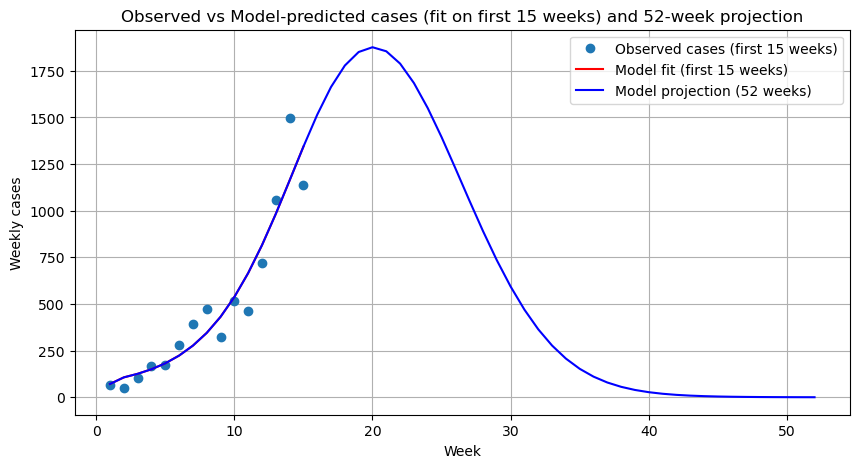

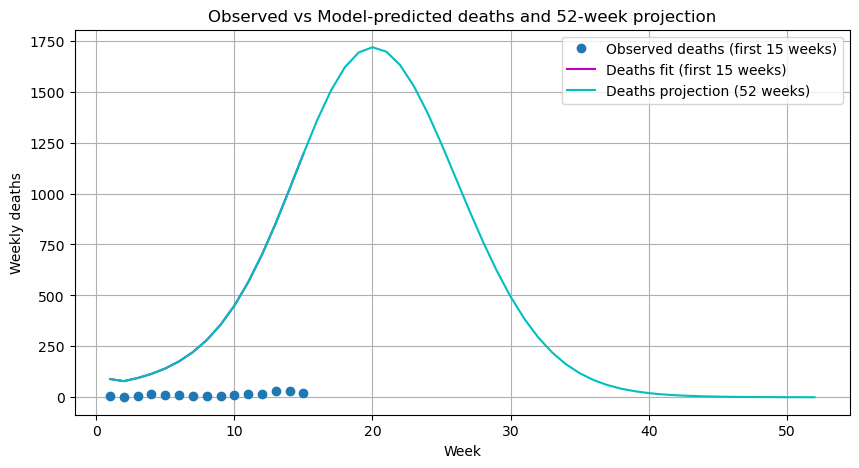

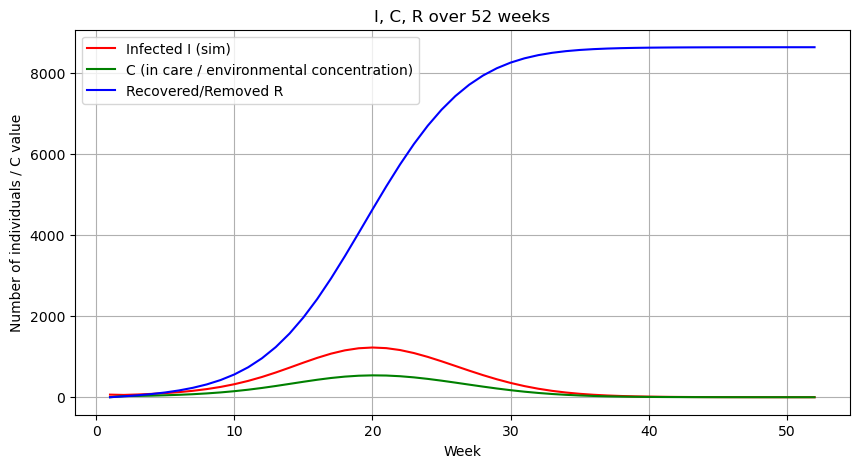

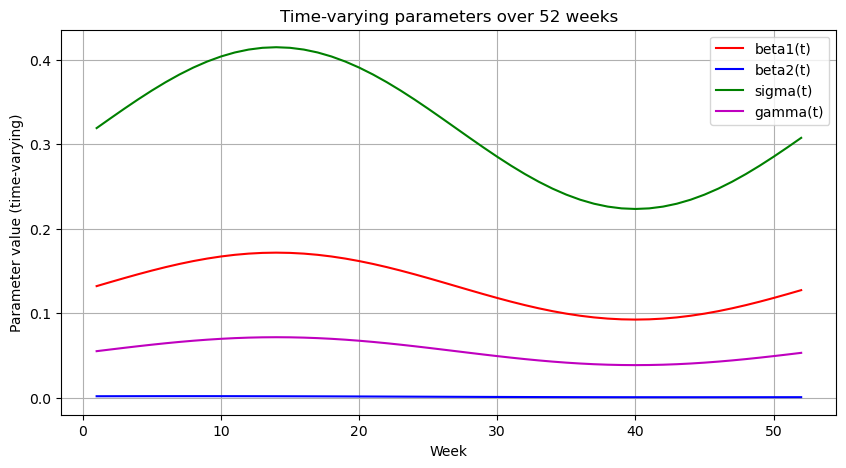

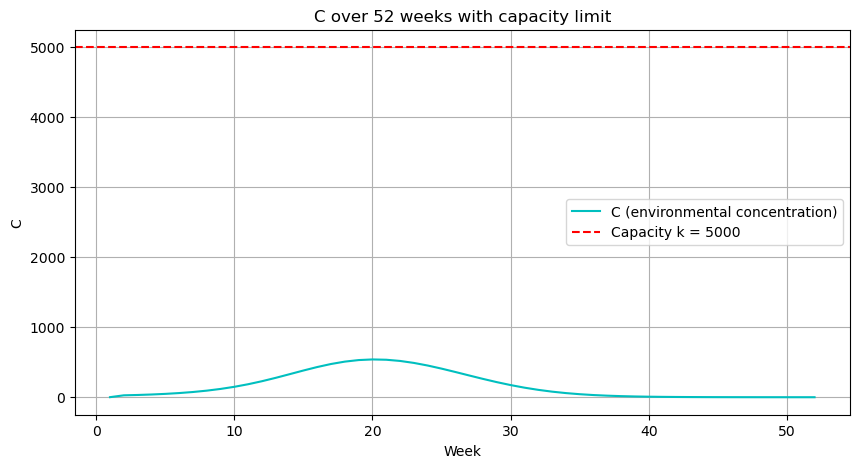

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# ------------------------------
# بيانات المستخدم (أسبوعية: أول 15 أسبوع)
# ------------------------------
weeks_fit = np.arange(1, 16)  # أسابيع بيانات الملاءمة (1..15)
cases_data = np.array([
    64, 52, 101, 168, 175,
    279, 393, 472, 324, 517,
    460, 722, 1059, 1495, 1140
], dtype=float)
deaths_data = np.array([
    4, 2, 7, 14, 11,
    12, 8, 7, 8, 13,
    18, 18, 30, 32, 21
], dtype=float)

# ------------------------------
# محاكاة لمدة سنة (52 أسبوع) بحسب طلبك
# ------------------------------
weeks_sim = np.arange(1, 53)  # 52 أسبوع (سنة واحدة)

# ------------------------------
# ثوابت/خيارات نموذجية
# ------------------------------
N = 1_000_000
k_capacity = 5000          # سعة استيعابية للمصدر/التركيز البيئي كما طلبت
season_amp = 0.30          # شدة التذبذب الموسمي (±30%)
dry_rate_base = 0.02       # معدل جفاف أسبوعي ثابت (يمكن جعله موسمي عن طريق dry_amp)
phi_max_default = 0.0      # تنقية افتراضية
theta_default = 0.0        # عزل افتراضي
vacc_rate_default = 0.0    # تطعيم اسبوعي افتراضي (نسبة من S)
ve_default = 0.8
vacc_delay_default = 2

# ------------------------------
# نموذج SEICR (ODE) مع معاملات زمنية (موسمية/تدخل/جفاف)
# المعادلات تحسب بدلالة الزمن (t بالايام) داخل solve_ivp
# ------------------------------
def seicr_model(t, y, N,
                beta1_base, beta2_base, sigma_base, gamma_base, mu,
                delta, eta,
                phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                dry_rate_base=0.0, season_amp=0.0, k_capacity=5000):
    # t بالايام -> نحسب الأسبوع المقابل (جعل المدد أسبوعي مهم للتذبذب)
    week = t / 7.0
    # عامل موسمي دوري سنوي (52 أسبوع)
    season_factor = 1.0 + season_amp * np.sin(2 * np.pi * week / 52.0)

    # معامل الجفاف يمكن أن يكون متناقص أُسّي عبر الأسابيع: (1-dry)^week
    dry_factor = (1 - dry_rate_base) ** week

    # معاملات زمنية (فعّالة)
    beta1 = beta1_base * (1 - theta) * season_factor
    beta2 = beta2_base * (1 - phi_max) * dry_factor * season_factor
    sigma = sigma_base * season_factor
    gamma = gamma_base * (1 + 0.5 * theta) * season_factor
    eta_eff = eta * (1 + 0.3 * theta)

    S, E, I, R, C = y

    # قوة العدوى
    lam = (beta1 * I / N) + (beta2 * C / (k_capacity + C))

    # معادلات
    dS = -lam * S - vacc_rate * S   # نخصم التطعيم كخروج من S (تبسيط)
    dE = lam * S - sigma * E
    dI = sigma * E - (gamma + mu) * I
    dR = gamma * I + vacc_rate * S * ve  # نعتبر التطعيم يذهب فورا إلى المناعة مع ve (تبسيط)
    dC = eta * I * (1 - C / k_capacity) - delta * C

    return [dS, dE, dI, dR, dC]

# ------------------------------
# دالة للمحاكاة عبر أسابيع محددة
# ترجع: weekly_cases, weekly_deaths, I_vals, R_vals, C_vals و time (أسابيع)
# weekly_cases = تقديري كـ sigma*E (معدل الدخول إلى I) مضروب في 7 (أيام/أسبوع)
# weekly_deaths = (mu*I + eta*C)*7 تقريبي (الوفيات من I وC)
# ------------------------------
def simulate_seicr_ode(weeks_array, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                       phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                       dry_rate_base=0.0, season_amp=0.0, k_capacity=5000,
                       I0=None):
    # تحويل الأسابيع إلى نقاط زمنية بالايام (نبدأ من اليوم 0)
    t_eval_days = ((weeks_array - weeks_array[0]) * 7.0)
    t_span = (t_eval_days[0], t_eval_days[-1])

    # بدايات الحالة
    if I0 is None:
        I0 = max(1.0, cases_data[0])  # استخدام أول قيمة حالات كـ I0 إن وُجدت
    S0 = max(N - I0, 0)
    E0 = I0 * 0.5  # تخمين بداية E (يمكن تعديل)
    R0 = 0.0
    C0 = 1.0
    y0 = [S0, E0, I0, R0, C0]

    sol = solve_ivp(seicr_model, t_span, y0,
                    args=(N, beta1, beta2, sigma, gamma, mu, delta, eta,
                          phi_max, theta, vacc_rate, ve, vacc_delay,
                          dry_rate_base, season_amp, k_capacity),
                    t_eval=t_eval_days, rtol=1e-6, atol=1e-8, method='RK45')

    if not sol.success:
        raise RuntimeError("ODE solver failed")

    S_vals, E_vals, I_vals, R_vals, C_vals = sol.y

    # تحويل المخرجات إلى حالات وأعداد أسبوعية تقريبية
    weekly_cases = np.maximum(sigma * E_vals * 7.0, 0.0)          # من E إلى I خلال الأسبوع
    weekly_deaths = np.maximum((mu * I_vals ) * 7.0, 0.0)

    # نرجع أيضا مسارات المعاملات المحسوبة عند نقاط الأسابيع لعمل الرسوم
    weeks_points = (t_eval_days / 7.0)  # يبدأ غالبا من 0..n
    season_factor_points = 1.0 + season_amp * np.sin(2 * np.pi * weeks_points / 52.0)
    dry_factor_points = (1 - dry_rate_base) ** weeks_points

    beta1_ts = beta1 * (1 - theta) * season_factor_points
    beta2_ts = beta2 * (1 - phi_max) * dry_factor_points * season_factor_points
    sigma_ts = sigma * season_factor_points
    gamma_ts = gamma * (1 + 0.5 * theta) * season_factor_points

    return (weekly_cases, weekly_deaths, I_vals, R_vals, C_vals, weeks_points,
            beta1_ts, beta2_ts, sigma_ts, gamma_ts)

# ------------------------------
# دالة للملاءمة: تستخدم بيانات الحالات (أسابيع 1..15)
# تُعيد معلمات مُقدَّرة
# ------------------------------
def fit_parameters(weeks_obs, cases_obs, N,
                   p0=None, bounds=None,
                   phi_max=0.0, theta=0.0, vacc_rate=0.0,
                   dry_rate_base=0.0, season_amp=0.0, k_capacity=5000):
    if p0 is None:
        p0 = [0.5, 0.3, 1/5, 0.4, 0.0001, 0.08, 0.1]  # β1,β2,σ,γ,μ,δ,η
    if bounds is None:
        lower = [0, 0, 1/12, 0.1, 0.00001, 0.01, 0]
        upper = [3, 3, 1/2, 1.0, 0.2, 0.001, 2.0]
        bounds = (lower, upper)

    def fit_func_short(weeks_input, beta1, beta2, sigma, gamma, mu, delta, eta):
        try:
            weekly_cases, _, _, _, _, _, _, _, _, _ = simulate_seicr_ode(
                weeks_input, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
                dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
                I0=cases_obs[0]
            )
        except RuntimeError:
            # لو فشل المحلل نرجع نان حتى curve_fit يتعامل
            return np.full_like(weeks_input, np.nan, dtype=float)
        # curve_fit يتوقع 1D array ملائمة لطول weeks_input
        return weekly_cases.astype(float)

    params_opt, cov = curve_fit(fit_func_short, weeks_obs, cases_obs, p0=p0, bounds=bounds, maxfev=20000)
    return params_opt

# ------------------------------
# تنفيذ الملاءمة على بيانات الأسابيع الأولى (1..15)
# ونحاكي لسنة كاملة (52 أسبوع) بالمعاملات المقدرة
# ------------------------------
# خيارات تدخل/موسم/جفاف (تقدر تغيّرها هنا)
phi_max = 0.3
theta = 0.2
vacc_rate = 0.00
dry_rate_base = 0.02
season_amp = 0.30

# إجراء الملاءمة
p0 = [0.7, 0.5, 1/5, 0.35, 0.03, 0.08, 0.15]   # تخمينات أولية أقرب للي أنت استخدمتهم سابقًا
bounds = ([0,0,1/12,0.05,0.0001,0.01,0],[3,3,1/2,1.0,0.2,1.0,2.0])
print("Fitting parameters to the first 15 weeks... (this may take some seconds)")
params_opt = fit_parameters(weeks_fit, cases_data, N, p0=p0, bounds=bounds,
                            phi_max=phi_max, theta=theta, vacc_rate=vacc_rate,
                            dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity)
beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit = params_opt

print("\nFitted parameters:")
print(f"beta1 = {beta1_fit:.6f}")
print(f"beta2 = {beta2_fit:.6f}")
print(f"sigma = {sigma_fit:.6f}")
print(f"gamma = {gamma_fit:.6f}")
print(f"mu    = {mu_fit:.6f}")
print(f"delta = {delta_fit:.6f}")
print(f"eta   = {eta_fit:.6f}")

# ------------------------------
# محاكاة سنة كاملة بالمعاملات المقدرة
# ------------------------------
(weekly_cases_sim, weekly_deaths_sim, I_sim, R_sim, C_sim,
 weeks_points_sim, beta1_ts, beta2_ts, sigma_ts, gamma_ts) = simulate_seicr_ode(
    weeks_sim, N,
    beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
    I0=cases_data[0]
)

# لتوافق محاور الرسم: weeks_points_sim بداية من 0 -> نححوها لأسابيع 1..52 للعروض
weeks_plot = weeks_points_sim + weeks_sim[0]  # عادة يعطي 0..51 لذا نضع 1..52
# لكن إن أردت تسمية محاور الأسبوع تبدأ من 1 إلى 52 استخدم weeks_sim مباشرة عند الرسم

# ------------------------------
# رسومات النتائج المطلوبة
# 1) بيانات الحالات (حقيقية) vs تنبؤات الملاءمة (لـ 15 أسبوع) + امتداد لسنة كاملة
# 2) الوفيات الحقيقية vs متوقعة (لنفس الفترة)
# 3) I و C و R على مدار السنة
# 4) القيم الموسمية للمعاملات beta1,beta2,sigma,gamma
# 5) C الموسمي مع خط السعة k=5000
# ------------------------------

# 1) Cases: رسم بيانات الملاءمة (15 أسبوع) مع توقع الملاءمة لنفس النقاط + محاكاة سنة كاملة
# نحصل أولاً على توقعات عند أسابيع الملاءمة (للمقارنة مع البيانات)
weekly_cases_fit_pred, weekly_deaths_fit_pred, _, _, _, _, _, _, _, _ = simulate_seicr_ode(
    weeks_fit, N,
    beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
    I0=cases_data[0]
)

plt.figure(figsize=(10,5))
plt.plot(weeks_fit, cases_data, 'o', label='Observed cases (first 15 weeks)')
plt.plot(weeks_fit, weekly_cases_fit_pred, '-r', label='Model fit (first 15 weeks)')
plt.plot(weeks_sim, weekly_cases_sim, '-b', label='Model projection (52 weeks)')
plt.xlabel("Week")
plt.ylabel("Weekly cases")
plt.title("Observed vs Model-predicted cases (fit on first 15 weeks) and 52-week projection")
plt.legend()
plt.grid(True)
plt.show()

# 2) Deaths: مقارنة (نقطة الملاءمة) ثم امتداد المحاكاة
weekly_deaths_fit_pred = simulate_seicr_ode(
    weeks_fit, N,
    beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
    I0=cases_data[0]
)[1]

plt.figure(figsize=(10,5))
plt.plot(weeks_fit, deaths_data, 'o', label='Observed deaths (first 15 weeks)')
plt.plot(weeks_fit, weekly_deaths_fit_pred, '-m', label='Deaths fit (first 15 weeks)')
plt.plot(weeks_sim, weekly_deaths_sim, '-c', label='Deaths projection (52 weeks)')
plt.xlabel("Week")
plt.ylabel("Weekly deaths")
plt.title("Observed vs Model-predicted deaths and 52-week projection")
plt.legend()
plt.grid(True)
plt.show()

# 3) I, C, R over 52 weeks
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, I_sim, '-r', label='Infected I (sim)')
plt.plot(weeks_sim, C_sim, '-g', label='C (in care / environmental concentration)')
plt.plot(weeks_sim, R_sim, '-b', label='Recovered/Removed R')
plt.xlabel("Week")
plt.ylabel("Number of individuals / C value")
plt.title("I, C, R over 52 weeks")
plt.legend()
plt.grid(True)
plt.show()

# 4) Parameters time series across weeks (beta1, beta2, sigma, gamma)
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, beta1_ts, '-r', label='beta1(t)')
plt.plot(weeks_sim, beta2_ts, '-b', label='beta2(t)')
plt.plot(weeks_sim, sigma_ts, '-g', label='sigma(t)')
plt.plot(weeks_sim, gamma_ts, '-m', label='gamma(t)')
plt.xlabel("Week")
plt.ylabel("Parameter value (time-varying)")
plt.title("Time-varying parameters over 52 weeks")
plt.legend()
plt.grid(True)
plt.show()

# 5) C seasonal / capacity
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, C_sim, '-c', label='C (environmental concentration)')
plt.axhline(k_capacity, color='r', linestyle='--', label=f'Capacity k = {k_capacity}')
plt.xlabel("Week")
plt.ylabel("C")
plt.title("C over 52 weeks with capacity limit")
plt.legend()
plt.grid(True)
plt.show()


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# ==============================
# بيانات المستخدم (سنة واحدة: 52 أسبوع)
# ==============================
weeks = np.arange(1, 53)  # 52 أسبوع (من 1 لحد 52)

# بيانات إصابات فعلية (مثال، استبدليها ببياناتك)
cases_data = np.array([
    64, 52, 101, 168, 175,
    279, 393, 472, 324, 517,
    460, 722, 1059, 1495, 1140,
    800, 600, 500, 450, 400,
    380, 360, 350, 340, 320,
    300, 280, 270, 260, 250,
    240, 230, 220, 210, 200,
    190, 180, 170, 160, 150,
    140, 130, 120, 110, 100,
    90, 80, 70, 60, 50, 40, 30, 20
], dtype=float)

# بيانات وفيات فعلية (مثال، استبدليها ببياناتك)
deaths_data = np.array([
    4, 2, 7, 14, 11,
    12, 8, 7, 8, 13,
    18, 18, 30, 32, 21,
    20, 18, 15, 14, 13,
    12, 11, 11, 10, 9,
    9, 8, 8, 7, 7,
    6, 6, 6, 5, 5,
    5, 4, 4, 4, 3,
    3, 3, 2, 2, 2,
    2, 2, 1, 1, 1, 1, 1, 1
], dtype=float)

# ==============================
# ثوابت عامة
# ==============================
mu = 0.001     # معدل وفيات أساسي
kappa = 1000   # ثابت الإشباع (للعدوى البيئية)
K = 5000       # السعة الاستيعابية للـ C

# ==============================
# معادلات SEICR + C (بالأسابيع)
# ==============================
def seicr_model(t, y, N, beta1, beta2, sigma, gamma, eta, epsilon):
    S, E, I, R, C = y
    lam = (beta1 * I / N) + beta2 * C / (kappa + C)  # قوة العدوى
    
    dS = - lam * S
    dE = lam * S - sigma * E
    dI = sigma * E - (gamma + mu) * I
    dR = gamma * I
    # معادلة C مع السعة الاستيعابية K
    dC = eta * I + epsilon * C * (1 - C / K)
    
    return [dS, dE, dI, dR, dC]

# ==============================
# دالة المحاكاة (بالأسابيع)
# ==============================
def simulate_seicr(weeks, N, beta1, beta2, sigma, gamma, eta, epsilon, I0=10):
    # القيم الابتدائية
    S0 = N - I0
    E0 = 0
    R0 = 0
    C0 = 1
    y0 = [S0, E0, I0, R0, C0]

    # المحاكاة مباشرة على الأسابيع
    t_span = [0, len(weeks)]
    t_eval = weeks  # التقييم عند كل أسبوع
    
    sol = solve_ivp(seicr_model, t_span, y0,
                    args=(N, beta1, beta2, sigma, gamma, eta, epsilon),
                    t_eval=t_eval, rtol=1e-6, atol=1e-8)
    
    if not sol.success:
        raise RuntimeError("فشل حل المعادلات")
    
    E_vals = sol.y[1]
    I_vals = sol.y[2]
    
    weekly_cases = sigma * E_vals     # الإصابات الجديدة أسبوعياً
    weekly_deaths = mu * I_vals       # الوفيات أسبوعياً
    
    return weekly_cases, weekly_deaths

# ==============================
# دالة الملاءمة (للإصابات فقط)
# ==============================
def fit_func(weeks, beta1, beta2, sigma, gamma, eta, epsilon):
    N = 1_000_000
    pred_cases, _ = simulate_seicr(weeks, N, beta1, beta2, sigma, gamma, eta, epsilon)
    return pred_cases

# ==============================
# تقدير المعاملات
# ==============================
p0 = [0.5, 0.1, 0.25, 0.25, 0.05, 0.01]  # قيم ابتدائية
bounds_lower = [0.01, 0.01, 1/5, 1/6, 0, 0]
bounds_upper = [np.inf, np.inf, 1/2, 1/3, 1, 1]
  
params, cov = curve_fit(fit_func, weeks, cases_data, 
                        p0=p0, bounds=(bounds_lower, bounds_upper))
beta1_fit, beta2_fit, sigma_fit, gamma_fit, eta_fit, epsilon_fit = params

print("المعاملات المقدرة:")
print(f"β1 = {beta1_fit:.4f}")
print(f"β2 = {beta2_fit:.4f}")
print(f"σ  = {sigma_fit:.4f}")
print(f"γ  = {gamma_fit:.4f}")
print(f"η  = {eta_fit:.4f}")
print(f"ε  = {epsilon_fit:.4f}")

# ==============================
# حساب الإصابات والوفيات
# ==============================
pred_cases, pred_deaths = simulate_seicr(weeks, 1_000_000, *params)

# ==============================
# رسم النتائج
# ==============================
plt.figure(figsize=(12,6))
plt.plot(weeks, cases_data, "o", label="إصابات فعلية")
plt.plot(weeks, pred_cases, "-r", label="إصابات متوقعة")
plt.plot(weeks, deaths_data, "s", label="وفيات فعلية")
plt.plot(weeks, pred_deaths, "--k", label="وفيات متوقعة")
plt.xlabel("الأسبوع")
plt.ylabel("عدد الحالات")
plt.legend()
plt.title("محاكاة SEICR مع C (K=5000) - الإصابات والوفيات (بالأسابيع)")
plt.grid(True)
plt.show()

ValueError: operands could not be broadcast together with shapes (52,) (53,) 

Fitting parameters to provided weeks (length = 15) ...

Fitted parameters:
beta1 = 0.164945
beta2 = 0.002404
sigma = 0.318891
gamma = 0.050000
mu    = 0.200000
delta = 0.999998
eta   = 0.493445


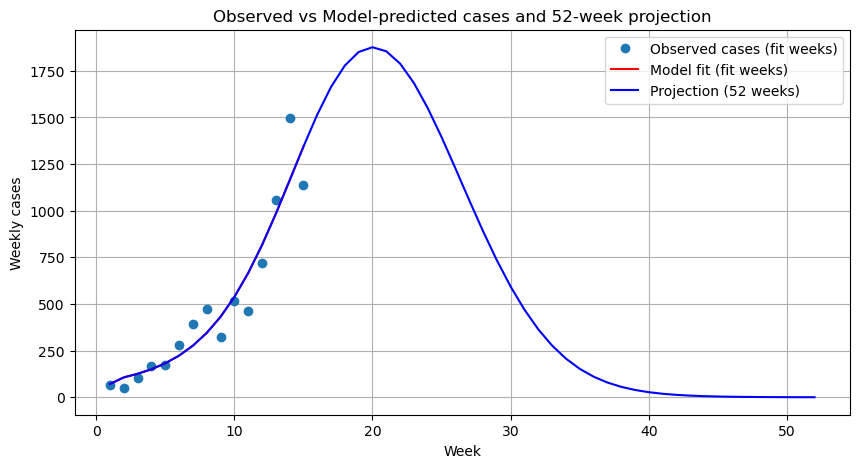

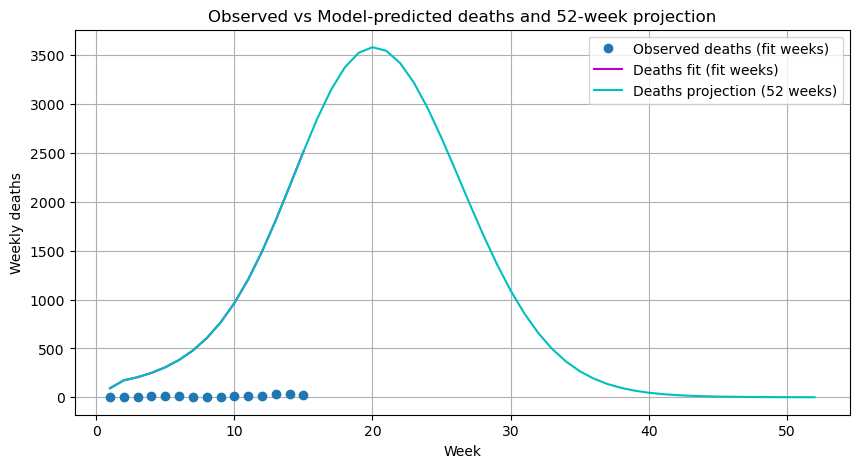

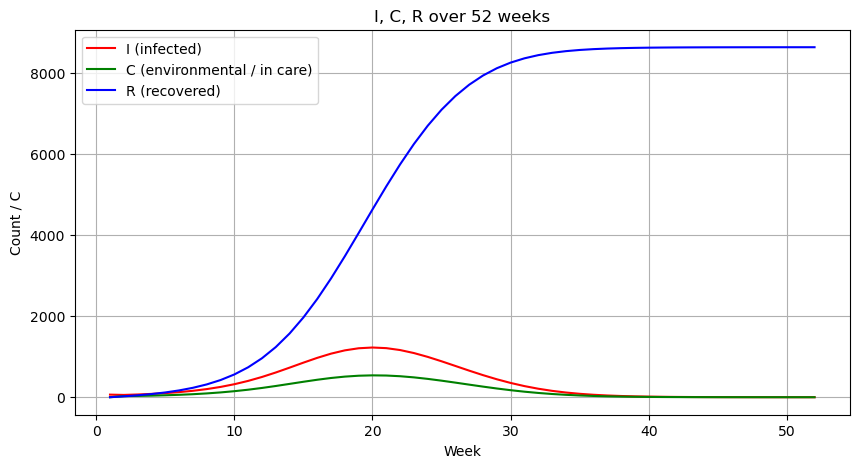

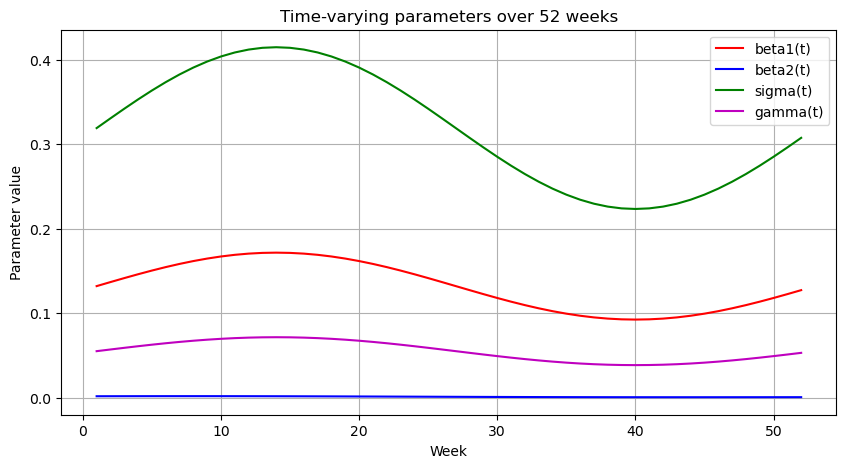

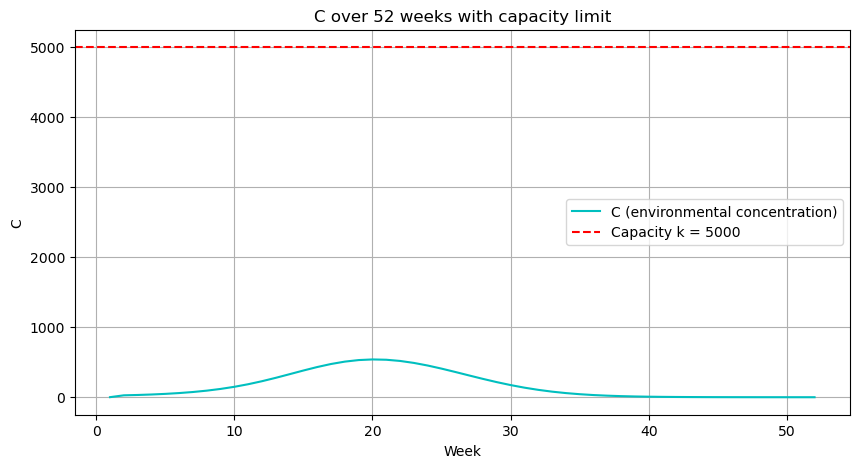

In [2]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# ------------------------------
# --- ضع بياناتك الأسبوعية هنا ---
# إذا عندك 52 أسبوع ضع مصفوفة طولها 52
# مثال: (حالياً مثال 15 أسبوع كما كنت سابقاً)
cases_data = np.array([
    64, 52, 101, 168, 175,
    279, 393, 472, 324, 517,
    460, 722, 1059, 1495, 1140
], dtype=float)

deaths_data = np.array([
    4, 2, 7, 14, 11,
    12, 8, 7, 8, 13,
    18, 18, 30, 32, 21
], dtype=float)
# --------------------------------

# استخدم طول بياناتك تلقائياً لأسابيع الملاءمة
weeks_fit = np.arange(1, len(cases_data) + 1)   # أسابيع الملاءمة (مثال: 1..52 لو كانت بياناتك 52)
# محاكاة لمدة سنة (52 أسبوع) لعرض المشروع الكامل
weeks_sim = np.arange(1, 53)

# ثوابت نموذجية
N = 1_000_000
k_capacity = 5000
season_amp = 0.30
dry_rate_base = 0.02
phi_max = 0.3
theta = 0.2
vacc_rate = 0.0
ve_default = 0.8
vacc_delay_default = 2

# ------------------------------
# تعريف نظام ODE (نفس النموذج السابق)
# ------------------------------
def seicr_model(t, y, N,
                beta1_base, beta2_base, sigma_base, gamma_base, mu,
                delta, eta,
                phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                dry_rate_base=0.0, season_amp=0.0, k_capacity=5000):
    week = t / 7.0
    season_factor = 1.0 + season_amp * np.sin(2 * np.pi * week / 52.0)
    dry_factor = (1 - dry_rate_base) ** week

    beta1 = beta1_base * (1 - theta) * season_factor
    beta2 = beta2_base * (1 - phi_max) * dry_factor * season_factor
    sigma = sigma_base * season_factor
    gamma = gamma_base * (1 + 0.5 * theta) * season_factor
    # eta kept as baseline modified by theta in other parts if needed

    S, E, I, R, C = y
    lam = (beta1 * I / N) + (beta2 * C / (k_capacity + C))

    dS = -lam * S - vacc_rate * S
    dE = lam * S - sigma * E
    dI = sigma * E - (gamma + mu) * I
    dR = gamma * I + vacc_rate * S * ve
    dC = eta * I * (1 - C / k_capacity) - delta * C

    return [dS, dE, dI, dR, dC]

# ------------------------------
# محاكاة ODE على نقاط أسابيع معينة
# ------------------------------
def simulate_seicr_ode(weeks_array, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                       phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                       dry_rate_base=0.0, season_amp=0.0, k_capacity=5000,
                       I0=None):
    t_eval_days = ((weeks_array - weeks_array[0]) * 7.0)
    t_span = (t_eval_days[0], t_eval_days[-1])

    if I0 is None:
        I0 = max(1.0, cases_data[0])
    S0 = max(N - I0, 0)
    E0 = I0 * 0.5
    R0 = 0.0
    C0 = 1.0
    y0 = [S0, E0, I0, R0, C0]

    sol = solve_ivp(seicr_model, t_span, y0,
                    args=(N, beta1, beta2, sigma, gamma, mu, delta, eta,
                          phi_max, theta, vacc_rate, ve, vacc_delay,
                          dry_rate_base, season_amp, k_capacity),
                    t_eval=t_eval_days, rtol=1e-6, atol=1e-8, method='RK45')

    if not sol.success:
        raise RuntimeError("ODE solver failed")

    S_vals, E_vals, I_vals, R_vals, C_vals = sol.y

    weekly_cases = np.maximum(sigma * E_vals * 7.0, 0.0)
    weekly_deaths = np.maximum((mu * I_vals + eta * C_vals) * 7.0, 0.0)

    weeks_points = (t_eval_days / 7.0)
    season_factor_points = 1.0 + season_amp * np.sin(2 * np.pi * weeks_points / 52.0)
    dry_factor_points = (1 - dry_rate_base) ** weeks_points

    beta1_ts = beta1 * (1 - theta) * season_factor_points
    beta2_ts = beta2 * (1 - phi_max) * dry_factor_points * season_factor_points
    sigma_ts = sigma * season_factor_points
    gamma_ts = gamma * (1 + 0.5 * theta) * season_factor_points

    return (weekly_cases, weekly_deaths, I_vals, R_vals, C_vals, weeks_points,
            beta1_ts, beta2_ts, sigma_ts, gamma_ts)

# ------------------------------
# دالة الملاءمة تستخدم طول بياناتك التلقائي
# ------------------------------
def fit_parameters(weeks_obs, cases_obs, N,
                   p0=None, bounds=None,
                   phi_max=0.0, theta=0.0, vacc_rate=0.0,
                   dry_rate_base=0.0, season_amp=0.0, k_capacity=5000):
    if p0 is None:
        p0 = [0.5, 0.3, 1/5, 0.4, 0.02, 0.08, 0.1]
    if bounds is None:
        lower = [0, 0, 1/12, 0.05, 0.0001, 0.01, 0]
        upper = [3, 3, 1/2, 1.0, 0.2, 1.0, 2.0]
        bounds = (lower, upper)

    def fit_func_short(weeks_input, beta1, beta2, sigma, gamma, mu, delta, eta):
        try:
            weekly_cases, _, _, _, _, _, _, _, _, _ = simulate_seicr_ode(
                weeks_input, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
                dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
                I0=cases_data[0]
            )
        except RuntimeError:
            return np.full_like(weeks_input, np.nan, dtype=float)
        return weekly_cases.astype(float)

    params_opt, cov = curve_fit(fit_func_short, weeks_obs, cases_obs, p0=p0, bounds=bounds, maxfev=30000)
    return params_opt

# ------------------------------
# نفِّذ الملاءمة على كامل بياناتك (طولها يُستخدم تلقائياً)
# ------------------------------
print("Fitting parameters to provided weeks (length = {}) ...".format(len(cases_data)))
p0 = [0.7, 0.5, 1/5, 0.35, 0.03, 0.08, 0.15]
bounds = ([0,0,1/12,0.05,0.0001,0.01,0],[3,3,1/2,1.0,0.2,1.0,2.0])

params_opt = fit_parameters(weeks_fit, cases_data, N, p0=p0, bounds=bounds,
                            phi_max=phi_max, theta=theta, vacc_rate=vacc_rate,
                            dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity)

beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit = params_opt

print("\nFitted parameters:")
print(f"beta1 = {beta1_fit:.6f}")
print(f"beta2 = {beta2_fit:.6f}")
print(f"sigma = {sigma_fit:.6f}")
print(f"gamma = {gamma_fit:.6f}")
print(f"mu    = {mu_fit:.6f}")
print(f"delta = {delta_fit:.6f}")
print(f"eta   = {eta_fit:.6f}")

# ------------------------------
# محاكاة سنة كاملة (52 أسبوع) بالمعاملات المقدرة
# ------------------------------
(weekly_cases_sim, weekly_deaths_sim, I_sim, R_sim, C_sim,
 weeks_points_sim, beta1_ts, beta2_ts, sigma_ts, gamma_ts) = simulate_seicr_ode(
    weeks_sim, N,
    beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
    I0=cases_data[0]
)

# ------------------------------
# رسومات: (1) حالات: بياناتك vs fit وامتداد 52 أسبوع
# ------------------------------
# توقع نموذج عند نقاط الملاءمة لمقارنتها بالبيانات
weekly_cases_fit_pred, weekly_deaths_fit_pred, _, _, _, _, _, _, _, _ = simulate_seicr_ode(
    weeks_fit, N, beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity, I0=cases_data[0]
)

plt.figure(figsize=(10,5))
plt.plot(weeks_fit, cases_data, 'o', label='Observed cases (fit weeks)')
plt.plot(weeks_fit, weekly_cases_fit_pred, '-r', label='Model fit (fit weeks)')
plt.plot(weeks_sim, weekly_cases_sim, '-b', label='Projection (52 weeks)')
plt.xlabel("Week")
plt.ylabel("Weekly cases")
plt.title("Observed vs Model-predicted cases and 52-week projection")
plt.legend()
plt.grid(True)
plt.show()

# (2) Deaths
plt.figure(figsize=(10,5))
plt.plot(weeks_fit, deaths_data, 'o', label='Observed deaths (fit weeks)')
plt.plot(weeks_fit, weekly_deaths_fit_pred, '-m', label='Deaths fit (fit weeks)')
plt.plot(weeks_sim, weekly_deaths_sim, '-c', label='Deaths projection (52 weeks)')
plt.xlabel("Week")
plt.ylabel("Weekly deaths")
plt.title("Observed vs Model-predicted deaths and 52-week projection")
plt.legend()
plt.grid(True)
plt.show()

# (3) I, C, R over 52 weeks
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, I_sim, '-r', label='I (infected)')
plt.plot(weeks_sim, C_sim, '-g', label='C (environmental / in care)')
plt.plot(weeks_sim, R_sim, '-b', label='R (recovered)')
plt.xlabel("Week")
plt.ylabel("Count / C")
plt.title("I, C, R over 52 weeks")
plt.legend()
plt.grid(True)
plt.show()

# (4) time-varying parameters
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, beta1_ts, '-r', label='beta1(t)')
plt.plot(weeks_sim, beta2_ts, '-b', label='beta2(t)')
plt.plot(weeks_sim, sigma_ts, '-g', label='sigma(t)')
plt.plot(weeks_sim, gamma_ts, '-m', label='gamma(t)')
plt.xlabel("Week")
plt.ylabel("Parameter value")
plt.title("Time-varying parameters over 52 weeks")
plt.legend()
plt.grid(True)
plt.show()

# (5) C with capacity line
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, C_sim, '-c', label='C (environmental concentration)')
plt.axhline(k_capacity, color='r', linestyle='--', label=f'Capacity k = {k_capacity}')
plt.xlabel("Week")
plt.ylabel("C")
plt.title("C over 52 weeks with capacity limit")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# ------------------------------
# --- ضع بياناتك الأسبوعية هنا ---
# إذا عندك 52 أسبوع ضع مصفوفة طولها 52
# مثال: (حالياً مثال 15 أسبوع كما كنت سابقاً)
cases_data = np.array([
    64, 52, 101, 168, 175,
    279, 393, 472, 324, 517,
    460, 722, 1059, 1495, 1140
], dtype=float)

deaths_data = np.array([
    4, 2, 7, 14, 11,
    12, 8, 7, 8, 13,
    18, 18, 30, 32, 21
], dtype=float)
# --------------------------------

# استخدم طول بياناتك تلقائياً لأسابيع الملاءمة
weeks_fit = np.arange(1, len(cases_data) + 1)   # أسابيع الملاءمة (مثال: 1..52 لو كانت بياناتك 52)
# محاكاة لمدة سنة (52 أسبوع) لعرض المشروع الكامل
weeks_sim = np.arange(1, 53)

# ثوابت نموذجية
N = 1_000_000
k_capacity = 5000
season_amp = 0.30
dry_rate_base = 0.02
phi_max = 0.3
theta = 0.2
vacc_rate = 0.0
ve_default = 0.8
vacc_delay_default = 2

# ------------------------------
# تعريف نظام ODE (نفس النموذج السابق)
# ------------------------------
def seicr_model(t, y, N,
                beta1_base, beta2_base, sigma_base, gamma_base, mu,
                delta, eta,
                phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                dry_rate_base=0.0, season_amp=0.0, k_capacity=5000):
    week = t / 7.0
    season_factor = 1.0 + season_amp * np.sin(2 * np.pi * week / 52.0)
    dry_factor = (1 - dry_rate_base) ** week

    beta1 = beta1_base * (1 - theta) * season_factor
    beta2 = beta2_base * (1 - phi_max) * dry_factor * season_factor
    sigma = sigma_base * season_factor
    gamma = gamma_base * (1 + 0.5 * theta) * season_factor
    # eta kept as baseline modified by theta in other parts if needed

    S, E, I, R, C = y
    lam = (beta1 * I / N) + (beta2 * C / (k_capacity + C))

    dS = -lam * S - vacc_rate * S
    dE = lam * S - sigma * E
    dI = sigma * E - (gamma + mu) * I
    dR = gamma * I + vacc_rate * S * ve
    dC = eta * I * (1 - C / k_capacity) - delta * C

    return [dS, dE, dI, dR, dC]

# ------------------------------
# محاكاة ODE على نقاط أسابيع معينة
# ------------------------------
def simulate_seicr_ode(weeks_array, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                       phi_max=0.0, theta=0.0, vacc_rate=0.0, ve=0.8, vacc_delay=2,
                       dry_rate_base=0.0, season_amp=0.0, k_capacity=5000,
                       I0=None):
    t_eval_days = ((weeks_array - weeks_array[0]) * 7.0)
    t_span = (t_eval_days[0], t_eval_days[-1])

    if I0 is None:
        I0 = max(1.0, cases_data[0])
    S0 = max(N - I0, 0)
    E0 = I0 * 0.5
    R0 = 0.0
    C0 = 1.0
    y0 = [S0, E0, I0, R0, C0]

    sol = solve_ivp(seicr_model, t_span, y0,
                    args=(N, beta1, beta2, sigma, gamma, mu, delta, eta,
                          phi_max, theta, vacc_rate, ve, vacc_delay,
                          dry_rate_base, season_amp, k_capacity),
                    t_eval=t_eval_days, rtol=1e-6, atol=1e-8, method='RK45')

    if not sol.success:
        raise RuntimeError("ODE solver failed")

    S_vals, E_vals, I_vals, R_vals, C_vals = sol.y

    weekly_cases = np.maximum(sigma * E_vals * 7.0, 0.0)
    weekly_deaths = np.maximum((mu * I_vals + eta * C_vals) * 7.0, 0.0)

    weeks_points = (t_eval_days / 7.0)
    season_factor_points = 1.0 + season_amp * np.sin(2 * np.pi * weeks_points / 52.0)
    dry_factor_points = (1 - dry_rate_base) ** weeks_points

    beta1_ts = beta1 * (1 - theta) * season_factor_points
    beta2_ts = beta2 * (1 - phi_max) * dry_factor_points * season_factor_points
    sigma_ts = sigma * season_factor_points
    gamma_ts = gamma * (1 + 0.5 * theta) * season_factor_points

    return (weekly_cases, weekly_deaths, I_vals, R_vals, C_vals, weeks_points,
            beta1_ts, beta2_ts, sigma_ts, gamma_ts)

# ------------------------------
# دالة الملاءمة تستخدم طول بياناتك التلقائي
# ------------------------------
def fit_parameters(weeks_obs, cases_obs, N,
                   p0=None, bounds=None,
                   phi_max=0.0, theta=0.0, vacc_rate=0.0,
                   dry_rate_base=0.0, season_amp=0.0, k_capacity=5000):
    if p0 is None:
        p0 = [0.5, 0.3, 1/5, 0.4, 0.02, 0.08, 0.1]
    if bounds is None:
        lower = [0, 0, 1/12, 0.05, 0.0001, 0.01, 0]
        upper = [3, 3, 1/2, 1.0, 0.2, 1.0, 2.0]
        bounds = (lower, upper)

    def fit_func_short(weeks_input, beta1, beta2, sigma, gamma, mu, delta, eta):
        try:
            weekly_cases, _, _, _, _, _, _, _, _, _ = simulate_seicr_ode(
                weeks_input, N, beta1, beta2, sigma, gamma, mu, delta, eta,
                phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
                dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
                I0=cases_data[0]
            )
        except RuntimeError:
            return np.full_like(weeks_input, np.nan, dtype=float)
        return weekly_cases.astype(float)

    params_opt, cov = curve_fit(fit_func_short, weeks_obs, cases_obs, p0=p0, bounds=bounds, maxfev=30000)
    return params_opt

# ------------------------------
# نفِّذ الملاءمة على كامل بياناتك (طولها يُستخدم تلقائياً)
# ------------------------------
print("Fitting parameters to provided weeks (length = {}) ...".format(len(cases_data)))
p0 = [0.7, 0.5, 1/5, 0.35, 0.03, 0.08, 0.15]
bounds = ([0,0,1/12,0.05,0.0001,0.01,0],[3,3,1/2,1.0,0.2,1.0,2.0])

params_opt = fit_parameters(weeks_fit, cases_data, N, p0=p0, bounds=bounds,
                            phi_max=phi_max, theta=theta, vacc_rate=vacc_rate,
                            dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity)

beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit = params_opt

print("\nFitted parameters:")
print(f"beta1 = {beta1_fit:.6f}")
print(f"beta2 = {beta2_fit:.6f}")
print(f"sigma = {sigma_fit:.6f}")
print(f"gamma = {gamma_fit:.6f}")
print(f"mu    = {mu_fit:.6f}")
print(f"delta = {delta_fit:.6f}")
print(f"eta   = {eta_fit:.6f}")

# ------------------------------
# محاكاة سنة كاملة (52 أسبوع) بالمعاملات المقدرة
# ------------------------------
(weekly_cases_sim, weekly_deaths_sim, I_sim, R_sim, C_sim,
 weeks_points_sim, beta1_ts, beta2_ts, sigma_ts, gamma_ts) = simulate_seicr_ode(
    weeks_sim, N,
    beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity,
    I0=cases_data[0]
)

# ------------------------------
# رسومات: (1) حالات: بياناتك vs fit وامتداد 52 أسبوع
# ------------------------------
# توقع نموذج عند نقاط الملاءمة لمقارنتها بالبيانات
weekly_cases_fit_pred, weekly_deaths_fit_pred, _, _, _, _, _, _, _, _ = simulate_seicr_ode(
    weeks_fit, N, beta1_fit, beta2_fit, sigma_fit, gamma_fit, mu_fit, delta_fit, eta_fit,
    phi_max=phi_max, theta=theta, vacc_rate=vacc_rate, ve=ve_default, vacc_delay=vacc_delay_default,
    dry_rate_base=dry_rate_base, season_amp=season_amp, k_capacity=k_capacity, I0=cases_data[0]
)

plt.figure(figsize=(10,5))
plt.plot(weeks_fit, cases_data, 'o', label='Observed cases (fit weeks)')
plt.plot(weeks_fit, weekly_cases_fit_pred, '-r', label='Model fit (fit weeks)')
plt.plot(weeks_sim, weekly_cases_sim, '-b', label='Projection (52 weeks)')
plt.xlabel("Week")
plt.ylabel("Weekly cases")
plt.title("Observed vs Model-predicted cases and 52-week projection")
plt.legend()
plt.grid(True)
plt.show()

# (2) Deaths
plt.figure(figsize=(10,5))
plt.plot(weeks_fit, deaths_data, 'o', label='Observed deaths (fit weeks)')
plt.plot(weeks_fit, weekly_deaths_fit_pred, '-m', label='Deaths fit (fit weeks)')
plt.plot(weeks_sim, weekly_deaths_sim, '-c', label='Deaths projection (52 weeks)')
plt.xlabel("Week")
plt.ylabel("Weekly deaths")
plt.title("Observed vs Model-predicted deaths and 52-week projection")
plt.legend()
plt.grid(True)
plt.show()

# (3) I, C, R over 52 weeks
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, I_sim, '-r', label='I (infected)')
plt.plot(weeks_sim, C_sim, '-g', label='C (environmental / in care)')
plt.plot(weeks_sim, R_sim, '-b', label='R (recovered)')
plt.xlabel("Week")
plt.ylabel("Count / C")
plt.title("I, C, R over 52 weeks")
plt.legend()
plt.grid(True)
plt.show()

# (4) time-varying parameters
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, beta1_ts, '-r', label='beta1(t)')
plt.plot(weeks_sim, beta2_ts, '-b', label='beta2(t)')
plt.plot(weeks_sim, sigma_ts, '-g', label='sigma(t)')
plt.plot(weeks_sim, gamma_ts, '-m', label='gamma(t)')
plt.xlabel("Week")
plt.ylabel("Parameter value")
plt.title("Time-varying parameters over 52 weeks")
plt.legend()
plt.grid(True)
plt.show()

# (5) C with capacity line
plt.figure(figsize=(10,5))
plt.plot(weeks_sim, C_sim, '-c', label='C (environmental concentration)')
plt.axhline(k_capacity, color='r', linestyle='--', label=f'Capacity k = {k_capacity}')
plt.xlabel("Week")
plt.ylabel("C")
plt.title("C over 52 weeks with capacity limit")
plt.legend()
plt.grid(True)
plt.show()

Fitting parameters to provided weeks (length = 15) ...
